In [1]:
import numpy as np

# VoronoiSite example trajectory analysis

For this example, we want to analyse a simulation trajectory using voronoi sites. 

We can define our sites by creating a series of `pymatgen` `Structure`s, using the `Structure.from_spacegroup()` method. Each structure contains only Na sites, using the coordinates from Ramos _et al. Chem. Mater._ 2018.

In [6]:
from pymatgen.symmetry.groups import SpaceGroup
from pymatgen.io.vasp import Poscar
sg = SpaceGroup('I41/acd:2')
all_na_structure = Poscar.from_file('./na_sn_all_na_new.POSCAR.vasp').structure

In [7]:
from pymatgen import Structure, Lattice
lattice = all_na_structure.lattice
na1 = Structure.from_spacegroup(sg='I41/acd:2', lattice=lattice, species=['Na'], coords=[[0.25, 0.0, 0.125]])
na2 = Structure.from_spacegroup(sg='I41/acd:2', lattice=lattice, species=['Na'], coords=[[0.00, 0.0, 0.125]])
na3 = Structure.from_spacegroup(sg='I41/acd:2', lattice=lattice, species=['Na'], coords=[[0.0, 0.25, 0.0]])
na4 = Structure.from_spacegroup(sg='I41/acd:2', lattice=lattice, species=['Na'], coords=[[0.0, 0.0, 0.0]])
na5 = Structure.from_spacegroup(sg='I41/acd:2', lattice=lattice, species=['Na'], coords=[[0.75, 0.25, 0.0]])
na6 = Structure.from_spacegroup(sg='I41/acd:2', lattice=lattice, species=['Na'], coords=[[0.5, 0.75, 0.625]])
i2  = Structure.from_spacegroup(sg='I41/acd:2', lattice=lattice, species=['Na'], coords=[[0.666, 0.1376, 0.05]])
na_structures = {'Na1': na1,
                 'Na2': na2,
                 'Na3': na3,
                 'Na4': na4,
                 'Na5': na5,
                 'Na6': na6, 
                 'i2': i2}

In [8]:
from site_analysis.voronoi_site import VoronoiSite
na1_sites = [VoronoiSite(s.frac_coords, label='Na1') for s in na1 ]
na2_sites = [VoronoiSite(s.frac_coords, label='Na2') for s in na2 ]
na3_sites = [VoronoiSite(s.frac_coords, label='Na3') for s in na3 ]
na4_sites = [VoronoiSite(s.frac_coords, label='Na4') for s in na4 ]
na5_sites = [VoronoiSite(s.frac_coords, label='Na5') for s in na5 ]
na6_sites = [VoronoiSite(s.frac_coords, label='Na6') for s in na6 ]
i2_sites  = [VoronoiSite(s.frac_coords, label='i2') for s in i2 ]
sites = na1_sites + na2_sites + na3_sites + na4_sites + na5_sites + na6_sites + i2_sites

In [9]:
from pymatgen.io.vasp import Poscar
structure = Poscar.from_file('POSCAR').structure
print(structure.composition)
# create Atom objects
from site_analysis.atom import atoms_from_species_string
atoms = atoms_from_species_string(structure, 'Na')
atoms[0:3]

Na88 Sn16 P8 S96


[site_analysis.Atom(index=0, in_site=None, frac_coords=None),
 site_analysis.Atom(index=1, in_site=None, frac_coords=None),
 site_analysis.Atom(index=2, in_site=None, frac_coords=None)]

We now create a `Trajectory` object

In [10]:
from site_analysis.trajectory import Trajectory
trajectory = Trajectory(sites=sites, atoms=atoms)
trajectory

To analyse the site occupation for a particular `pymatgen` `Structure`:

In [11]:
trajectory.analyse_structure(structure)

In [12]:
np.array(trajectory.atom_sites)

array([16, 32, 36, 20,  3, 38, 34, 23,  5, 33, 35, 19, 37, 21, 24, 12, 28,
       46, 30, 42, 26, 47, 31, 25, 41, 43, 27, 29, 50, 54, 79, 53, 49, 51,
       64, 58, 62, 61, 63, 59, 91, 83, 89, 81, 90, 82, 52, 80, 95, 87, 57,
       93, 86, 94, 92, 84, 48, 76, 78, 68, 70, 60, 77, 66, 55, 75, 65, 72,
       73, 67, 74, 69, 13, 18,  4, 17, 14,  6,  7, 15,  9,  1,  8,  0,  2,
       44, 45, 11])

In [13]:
from pymatgen.io.vasp import Xdatcar
trajectory.reset()
xdatcar = Xdatcar('XDATCAR')
for timestep, s in enumerate(xdatcar.structures):
    trajectory.append_timestep(s, t=timestep)

Rough example for collecting only occupied sites, and counting their site types:

In [14]:
from collections import Counter
c = Counter()
for site in trajectory.sites:
    c[site.label] += len([ 1 for ts in site.trajectory if len(ts)>0 ])
for k, v in c.items():
    print( k, v/len(trajectory))

Na1 15.35
Na2 29.75
Na3 12.4
Na4 15.15
Na5 15.15
Na6 0.0
i2 0.2


vs. all sites:

In [15]:
c_sites = Counter(trajectory.site_labels())
c_sites

Counter({'Na1': 16,
         'Na2': 32,
         'Na3': 16,
         'Na4': 16,
         'Na5': 16,
         'Na6': 8,
         'i2': 32})

In [17]:
trajectory.reset()

xdatcar = Xdatcar('XDATCAR_Sn')

trajectory.trajectory_from_structures( xdatcar.structures, progress='notebook')

In [19]:
n_timesteps = len(trajectory.timesteps)
c_sites = Counter(trajectory.site_labels())
c = Counter()
p_occ = {}
for site in trajectory.sites:
    c[site.label] += len([ 1 for ts in site.trajectory if len(ts)>0 ])
for k, v in c.items():
    p_occ[k] = v / c_sites[k] / n_timesteps
p_occ

{'Na1': 0.93375,
 'Na2': 0.895625,
 'Na3': 0.915,
 'Na4': 0.9427083333333334,
 'Na5': 0.9120833333333334,
 'Na6': 0.0,
 'i2': 0.0026041666666666665}

In [20]:
# check total average occupation = 88 atoms
for k,v in c.items():
    print( k, p_occ[k]*c_sites[k])
print( sum( [ p_occ[k] * c_sites[k] for k, v in c.items()]))

Na1 14.94
Na2 28.66
Na3 14.64
Na4 15.083333333333334
Na5 14.593333333333334
Na6 0.0
i2 0.08333333333333333
88.0


In [34]:
def residence_times(atom_trajectory):
    """Calculates the numbers of sequential timesteps when an atom
    occupies the same site.
    
    Args:
        atom_trajectory (list): List of site indices.
        
    Returns:
        (dict)
        
    Example:
        >>> atom_trajectory = [3, 3, 3, 7, 7, 5, 3]
        >>> residence_times(atom_trajectory)
        {3: [3, 1], 7: [2], 5: [1]}
        
    """
    r_times = {}
    current_site = None
    for site in atom_trajectory:
        if site != current_site:
            if site in r_times:
                r_times[site].append(1)
            else:
                r_times[site] = [1]
        else:
            r_times[site][-1] += 1
        current_site = site
    return r_times   

In [35]:
residence_times([3, 3, 3, 7, 7, 5, 3])

{3: [3, 1], 7: [2], 5: [1]}

In [36]:
residence_times(trajectory.atoms[0].trajectory)

{16: [300]}

In [44]:
# Look at the site trajectory of atom 0:
r_times = []
for a in trajectory.atoms:
    rt = residence_times(a.trajectory)
    for k, v in rt.items():
        r_times.extend(v)

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

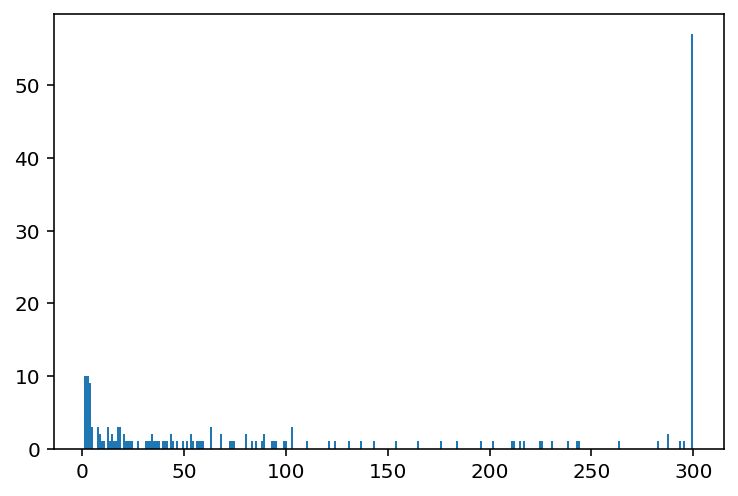

In [49]:
plt.hist(r_times, bins=300)
plt.show()

In [38]:
def smooth_trajectory(t):
    for i in range(len(t)-2):
        if t[i] == t[i+2]:
            t[i+1] = t[i]
    return t

In [41]:
t = [0,0,0,1,0,1,1]
smooth_trajectory(t)

[0, 0, 0, 0, 0, 1, 1]

In [42]:
for a in trajectory.atoms:
    print(residence_times(smooth_trajectory(a.trajectory)))

{16: [300]}
{32: [300]}
{36: [296], 83: [4]}
{20: [300]}
{3: [110, 121], 22: [68], 112: [1]}
{38: [300]}
{34: [300]}
{23: [300]}
{5: [300]}
{33: [300]}
{35: [300]}
{19: [300]}
{37: [244], 7: [56]}
{21: [300]}
{24: [131, 103], 3: [3], 95: [63]}
{12: [184, 94], 40: [22]}
{28: [100, 15, 17, 80], 95: [18, 34, 20, 2, 7], 131: [3, 1, 1, 2]}
{46: [300]}
{30: [300]}
{42: [300]}
{26: [300]}
{47: [300]}
{31: [300]}
{25: [226], 8: [74]}
{41: [243], 84: [57]}
{43: [300]}
{10: [202, 95], 27: [3]}
{29: [300]}
{50: [300]}
{54: [300]}
{79: [300]}
{53: [283], 89: [17]}
{49: [300]}
{51: [300]}
{64: [31, 93], 56: [176]}
{58: [300]}
{62: [300]}
{61: [300]}
{63: [300]}
{59: [300]}
{91: [300]}
{83: [288], 53: [12]}
{89: [196], 121: [1], 22: [103]}
{81: [300]}
{90: [300]}
{82: [300]}
{52: [68, 53, 85], 88: [53, 40], 120: [1]}
{80: [300]}
{95: [23, 58], 57: [2, 217]}
{87: [59, 239], 117: [1], 40: [1]}
{57: [12], 85: [288]}
{93: [300]}
{86: [300]}
{94: [99, 137], 27: [63], 132: [1]}
{92: [300]}
{84: [212], 56: